In [1]:
import pandas as pd 
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [2]:
df = pd.read_csv("merge_distance_intensity.csv")

In [4]:
df.dropna(inplace=True)

df["damage_grade"] = df["damage_grade"].str.replace("Grade ", "")
df["damage_grade"] = df["damage_grade"].astype(int)
rubble = ["Damaged-Rubble unclear", "Damaged-Rubble clear", "Damaged-Rubble Clear-New building built"]
damage = ["Damaged-Used in risk", "Damaged-Repaired and used", "Damaged-Not used"]
landslide = "Covered by landslide"
nd = "Not damaged"

df["condition_post_eq"] = df["condition_post_eq"].replace(rubble, 2)
df["condition_post_eq"] = df["condition_post_eq"].replace(damage, 1)
df["condition_post_eq"] = df["condition_post_eq"].replace(landslide, 3)
df["condition_post_eq"] = df["condition_post_eq"].replace(nd, 0)

df["land_surface_condition"] = df["land_surface_condition"].replace("Flat", 0)
df["land_surface_condition"] = df["land_surface_condition"].replace("Moderate slope", 1)
df["land_surface_condition"] = df["land_surface_condition"].replace("Steep slope", 2)

df["foundation_type"] = df["foundation_type"].replace("Other",0)
df["foundation_type"] = df["foundation_type"].replace("Mud mortar-Stone/Brick",1)
df["foundation_type"] = df["foundation_type"].replace("Cement-Stone/Brick",1)
df["foundation_type"] = df["foundation_type"].replace("Bamboo/Timber",3)
df["foundation_type"] = df["foundation_type"].replace("RC",2)

df["roof_type"] = df["roof_type"].replace("RCC/RB/RBC",0)
df["roof_type"] = df["roof_type"].replace("Bamboo/Timber-Light roof",1)
df["roof_type"] = df["roof_type"].replace("Bamboo/Timber-Heavy roof",2)

df["ground_floor_type"] = df["ground_floor_type"].replace("Mud",1)
df["ground_floor_type"] = df["ground_floor_type"].replace("Brick/Stone",2)
df["ground_floor_type"] = df["ground_floor_type"].replace("RC",3)
df["ground_floor_type"] = df["ground_floor_type"].replace("Timber",4)
df["ground_floor_type"] = df["ground_floor_type"].replace("Other",0)

df["other_floor_type"] = df["other_floor_type"].replace("Not applicable",0)
df["other_floor_type"] = df["other_floor_type"].replace("TImber/Bamboo-Mud",3)
df["other_floor_type"] = df["other_floor_type"].replace("Timber-Planck",2)
df["other_floor_type"] = df["other_floor_type"].replace("RCC/RB/RBC",1)

df["position"] = df["position"].replace("Not attached",0)
df["position"] = df["position"].replace("Attached-1 side",1)
df["position"] = df["position"].replace("Attached-2 side",2)
df["position"] = df["position"].replace("Attached-3 side",3)

df = pd.get_dummies(data = df, columns = ["plan_configuration"])



In [7]:
X = df[['count_floors_pre_eq', 'age_building',
       'plinth_area_sq_ft', 'height_ft_pre_eq',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other', 'plan_configuration_Building with Central Courtyard',
       'plan_configuration_E-shape', 'plan_configuration_H-shape',
       'plan_configuration_L-shape', 'plan_configuration_Multi-projected',
       'plan_configuration_Others', 'plan_configuration_Rectangular',
       'plan_configuration_Square', 'plan_configuration_T-shape',
       'plan_configuration_U-shape', "Intensity"]]
y = df["damage_grade"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0, stratify=y)

In [25]:
import xgboost as xgb
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test)
params = {"max_depth": 15, "objective":"multi:softmax", "num_class":6, "n_gpus":0}

In [26]:
bst = xgb.train(params,dtrain)

In [27]:
pred = bst.predict(dtest)

              precision    recall  f1-score   support

           1       0.59      0.73      0.65     13537
           2       0.40      0.22      0.28     14523
           3       0.42      0.33      0.37     23075
           4       0.48      0.43      0.45     31780
           5       0.66      0.81      0.72     49342

    accuracy                           0.56    132257
   macro avg       0.51      0.50      0.50    132257
weighted avg       0.54      0.56      0.54    132257

0.5617850094891008


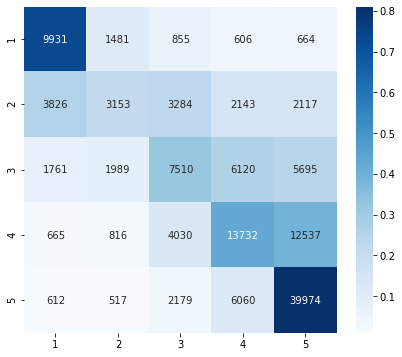

In [35]:
print(classification_report(y_test, pred))
cm = confusion_matrix(y_test, pred)
print(f1_score(y_test,pred,average = 'micro'))
def plot_confusion_matrix(cm, classes, normalized=True, cmap='Blues'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)
        
plot_confusion_matrix(cm, classes = [1,2,3,4,5])

In [156]:
selected_features = ['foundation_type', 
                     'plinth_area_sq_ft', 
                     'height_ft_pre_eq',
                     'count_floors_pre_eq',
                     'land_surface_condition',
                     'has_superstructure_bamboo', 'Intensity', 'ground_floor_type','roof_type']
train_values_subset = X_train[selected_features]
test_values = X_test[selected_features]

dtrain = xgb.DMatrix(data=train_values_subset, label=y_train)
dtest = xgb.DMatrix(data=test_values)

In [157]:
bst = xgb.train(params,dtrain)
pred = bst.predict(dtest)
print(classification_report(y_test, pred))
print(f1_score(y_test,pred,average = 'micro'))

              precision    recall  f1-score   support

           1       0.55      0.69      0.61     13537
           2       0.38      0.20      0.26     14523
           3       0.40      0.31      0.35     23075
           4       0.46      0.43      0.45     31780
           5       0.65      0.79      0.72     49342

    accuracy                           0.55    132257
   macro avg       0.49      0.49      0.48    132257
weighted avg       0.52      0.55      0.53    132257

0.5467612300294125


In [163]:
from imblearn.over_sampling import SMOTE
smote = SMOTE("minority")
X_sm, y_sm = smote.fit_sample(train_values_subset, y_train)
dtrain = xgb.DMatrix(data=X_sm, label=y_train)
dtest = xgb.DMatrix(data=y_sm)

In [164]:
bst = xgb.train(params,dtrain)
pred = bst.predict(dtest)
print(classification_report(y_test, pred))
print(f1_score(y_test,pred,average = 'micro'))

XGBoostError: [20:57:52] C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/multiclass_obj.cu:53: Check failed: preds.Size() == (static_cast<size_t>(param_.num_class) * info.labels_.Size()): SoftmaxMultiClassObj: label size and pred size does not match.
label.Size() * num_class: 3174150
num_class: 6
preds.Size(): 4033464

In [ ]:
in_sample_preds = clf.predict(test_values)
f1_score(y_test, in_sample_preds, average='micro')

In [194]:
# v3: xgb with weights tweaked
model = xgb.XGBClassifier()

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 (y_train))
w_array = np.ones(y_train.shape[0], dtype = "float")
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val-1]

v3_model = model.fit(X_train, y_train, sample_weight=w_array)

array([0.83232379, 0.83232379, 0.83232379, ..., 1.14631636, 1.14631636,
       1.14631636])

              precision    recall  f1-score   support

           1       0.54      0.78      0.64     13537
           2       0.32      0.31      0.32     14523
           3       0.38      0.38      0.38     23075
           4       0.46      0.46      0.46     31780
           5       0.75      0.67      0.71     49342

    accuracy                           0.54    132257
   macro avg       0.49      0.52      0.50    132257
weighted avg       0.55      0.54      0.54    132257



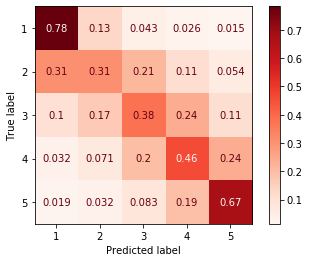

In [188]:
v3_pred = v3_model.predict(X_test)
print(classification_report(y_test, v3_pred))
v3_disp = plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Reds,normalize="true")

In [189]:
print(f1_score(y_test,v3_pred,average = 'micro'))

0.5413172837732596


In [204]:
# v3: xgb with weights tweaked
model = xgb.XGBClassifier()

from imblearn.over_sampling import SMOTE
smote = SMOTE("minority")
X_sm, y_sm = smote.fit_sample(X_train, y_train)

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_sm),
                                                 (y_sm))
w_array = np.ones(y_train.shape[0], dtype = "float")
for i, val in enumerate(y_sm):
    w_array[i] = class_weights[val-1]

X_sm = pd.DataFrame(data=X_sm, columns = ['count_floors_pre_eq', 'age_building',
       'plinth_area_sq_ft', 'height_ft_pre_eq',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other', 'plan_configuration_Building with Central Courtyard',
       'plan_configuration_E-shape', 'plan_configuration_H-shape',
       'plan_configuration_L-shape', 'plan_configuration_Multi-projected',
       'plan_configuration_Others', 'plan_configuration_Rectangular',
       'plan_configuration_Square', 'plan_configuration_T-shape',
       'plan_configuration_U-shape', "Intensity"])
v3_model = model.fit(X_sm, y_sm, sample_weight=w_array)

IndexError: index 529025 is out of bounds for axis 0 with size 529025

In [ ]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'multi:softmax',
}

params['eval_metric'] = "merror"
num_boost_round = 999
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label =y_test)

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10)

In [ ]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'merror'},
    early_stopping_rounds=10
)
cv_results

In [ ]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [ ]:
# Define initial best params and MAE
min_merror = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'merror'},
        early_stopping_rounds=10
    )    # Update best MAE
    mean_merror = cv_results['test-merror-mean'].min()
    boost_rounds = cv_results['test-merror-mean'].argmin()
    print("\tMERROR {} for {} rounds".format(mean_merror, boost_rounds))
    if mean_merror < min_merror:
        min_merror = mean_merror
        best_params = (max_depth,min_child_weight)
        
        print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_merror))